In [1]:
import pandas as pd 
# Load and preprocess
df = pd.read_csv("D:\\AT dataset and papers\\sp500_newdata.csv")
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df = df.sort_values('Date')
df.set_index('Date', inplace=True)


In [4]:
df

,Close,High,Low,Open,Volume
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000
...,...,...,...,...,...
2025-02-21,6013.129883,6114.819824,6008.560059,6114.100098,5434560000
2025-02-24,5983.250000,6043.649902,5977.830078,6026.689941,4990120000
2025-02-25,5955.250000,5992.649902,5908.490234,5982.729980,5374690000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1296 entries, 2020-01-02 to 2025-02-27
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   1296 non-null   float64
 1   High    1296 non-null   float64
 2   Low     1296 non-null   float64
 3   Open    1296 non-null   float64
 4   Volume  1296 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 60.8 KB


In [6]:
df.isnull().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [7]:
df.describe()

,Close,High,Low,Open,Volume
count,1296.000000,1296.000000,1296.000000,1296.000000,1.296000e+03
mean,4310.923180,4335.432276,4283.410622,4310.321869,4.385512e+09
std,811.890790,810.300148,813.572528,812.089628,1.032238e+09
min,2237.399902,2300.729980,2191.860107,2290.709961,1.639500e+09
25%,3827.660095,3859.357421,3800.265076,3834.012451,3.759472e+09
50%,4231.245118,4266.719971,4207.229981,4233.820069,4.136515e+09
75%,4689.185181,4709.022339,4666.385009,4690.642334,4.733785e+09
max,6144.149902,6147.430176,6111.149902,6134.500000,9.976520e+09


In [8]:
#Skewness and Kutosis
features = ['Open', 'Close', 'High', 'Low', 'Volume']
selected_df = df[features]

# Calculate skewness and kurtosis
skewness = selected_df.skew()
kurtosis = selected_df.kurt()  # excess kurtosis (normal dist = 0)

# Combine into a summary table
stats_df = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurtosis
})
print(stats_df)

        Skewness  Kurtosis
Open    0.315195 -0.200552
Close   0.311056 -0.200604
High    0.323994 -0.210294
Low     0.298462 -0.189986
Volume  1.765585  4.486605


In [9]:
from scipy.stats import shapiro
import numpy as np
close=df['Close']
# Shapiro-Wilk Test
stat, p = shapiro(close)
print(f"Shapiro-Wilk Test: W = {stat:.4f}, p-value = {p:.4f}")
if p > 0.05:
    print("Data appears to be normally distributed.")
else:
    print("Data is not normally distributed.")


Shapiro-Wilk Test: W = 0.9746, p-value = 0.0000
Data is not normally distributed.


In [10]:
from pingouin import multivariate_normality

# Select relevant features and drop NaNs
features = df[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()

# Apply Mardia's Test
result = multivariate_normality(features, alpha=0.05)

print(result)

HZResults(hz=5184, pval=0.0, normal=False)


In [11]:
#Stationary test 
from statsmodels.tsa.stattools import adfuller
close_prices = df['Close']
result = adfuller(close_prices)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
# If p-value > 0.05, differencing is likely needed.

ADF Statistic: -0.4644062165369651
p-value: 0.8987772334691909


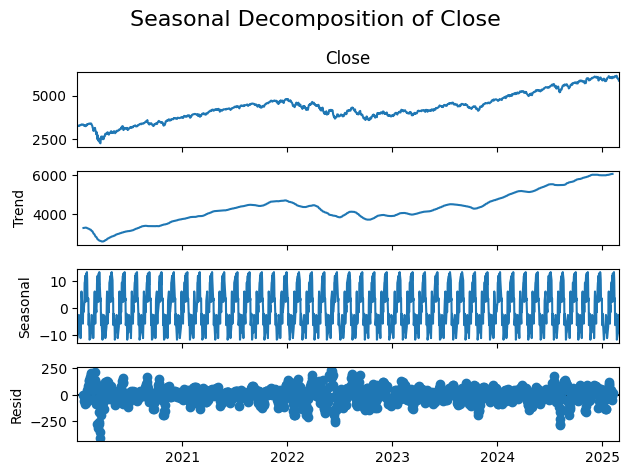

In [12]:
#Seasonality check 
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
result = seasonal_decompose(df['Close'], model='additive', period=30)  # try period=30 for monthly or 5 for weekly

# Plot
result.plot()
plt.suptitle("Seasonal Decomposition of Close", fontsize=16)
plt.tight_layout()
plt.show()


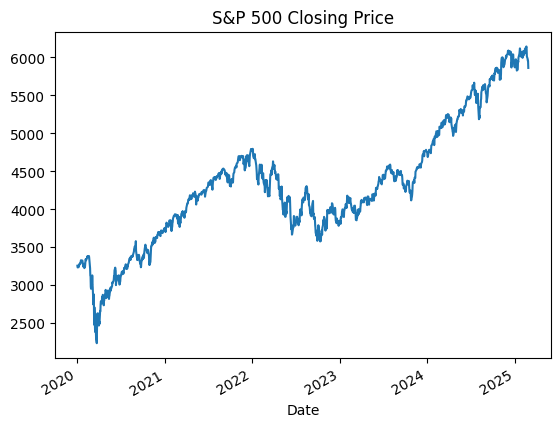

In [13]:
#Visualize original Close price trend
import matplotlib.pyplot as plt
df['Close'].plot(title='S&P 500 Closing Price')
plt.show()


In [14]:
# IQR-based outlier clipping
Q1 = df['Close'].quantile(0.25)
Q3 = df['Close'].quantile(0.75)
IQR = Q3 - Q1
df['Close'] = df['Close'].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)


In [15]:
# Log transform
df['Log_Close'] = np.log(df['Close'])


In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
import ta

# Lag & rolling features
df['Log_Close_t-1'] = df['Log_Close'].shift(1)
df['Log_Close_t-2'] = df['Log_Close'].shift(2)
df['Volume_t-1'] = df['Volume'].shift(1)
df['Log_Close_3day_avg'] = df['Log_Close'].rolling(3).mean().shift(1)
df['Log_Close_7day_avg'] = df['Log_Close'].rolling(7).mean().shift(1)

# Technical indicators
df['SMA_10'] = ta.trend.sma_indicator(df['Close'], window=10)
df['EMA_10'] = ta.trend.ema_indicator(df['Close'], window=10)
df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
df['MACD'] = ta.trend.macd_diff(df['Close'])
bb = ta.volatility.BollingerBands(df['Close'], window=20)
df['BB_Upper'] = bb.bollinger_hband()
df['BB_Lower'] = bb.bollinger_lband()

# Drop missing values
df.dropna(inplace=True)


In [17]:
import numpy as np
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD
from ta.volatility import AverageTrueRange, BollingerBands
from ta.volume import OnBalanceVolumeIndicator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import seaborn as sns
import random
import os
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

# Calculate returns
df['Return'] = df['Close'].pct_change()
df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))

# Technical indicators
df['ATR'] = AverageTrueRange(high=df['High'], low=df['Low'], close=df['Close']).average_true_range()

# Bollinger Bands
bb = BollingerBands(close=df['Close'])
df['BB_Width'] = bb.bollinger_hband() - bb.bollinger_lband()

# Stochastic Oscillator
stoch = StochasticOscillator(high=df['High'], low=df['Low'], close=df['Close'])
df['Stoch_K'] = stoch.stoch()
df['Stoch_D'] = stoch.stoch_signal()


# Volatility context features
df['Rolling_STD_10'] = df['LogReturn'].rolling(10).std()
df['Rolling_Mean_10'] = df['LogReturn'].rolling(10).mean()
df['MA_5'] = df['Close'].rolling(5).mean()
df['MA_20'] = df['Close'].rolling(20).mean()
df['MA_Crossover'] = df['MA_5'] - df['MA_20']
df['Price_vs_MA10'] = df['Close'] / df['Close'].rolling(10).mean()

# Z-Score of returns
df['ZScore_10'] = (df['LogReturn'] - df['LogReturn'].rolling(10).mean()) / df['LogReturn'].rolling(10).std()

# Volatility-adjusted return
df['VolAdj_Return'] = df['LogReturn'] / df['Rolling_STD_10']

# Drop NaNs
df.dropna(inplace=True)

# Define features and target
features = [
    'Log_Close_t-1', 'Log_Close_t-2', 'Volume_t-1',
    'Log_Close_3day_avg', 'Log_Close_7day_avg',
    'SMA_10', 'EMA_10', 'RSI', 'MACD', 'BB_Upper', 'BB_Lower','BB_Width','Stoch_K', 'Stoch_D','ATR','MA_Crossover', 'Price_vs_MA10',
    'ZScore_10', 'VolAdj_Return','Rolling_STD_10', 'Rolling_Mean_10'
]
target = 'LogReturn'


In [23]:
df.reset_index(inplace=True)

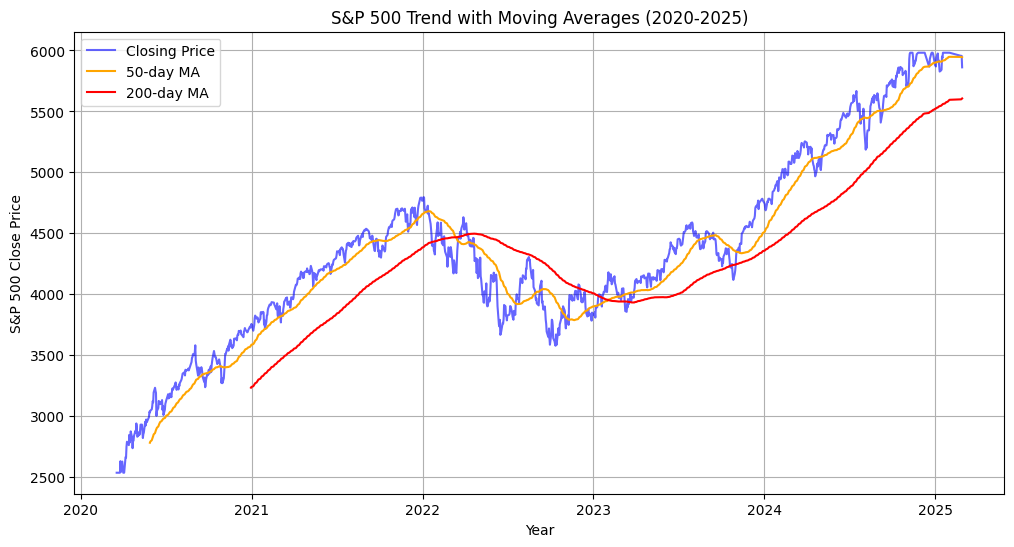

In [24]:
#EDA
#Compute Moving Averages
df['MA_50'] = df['Close'].rolling(window=50).mean()  # Short-term trend
df['MA_200'] = df['Close'].rolling(window=200).mean()  # Long-term trend

# Plot Closing Price with Moving Averages
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], color='blue', label="Closing Price", alpha=0.6)
plt.plot(df['Date'], df['MA_50'], color='orange', label="50-day MA", linewidth=1.5)
plt.plot(df['Date'], df['MA_200'], color='red', label="200-day MA", linewidth=1.5)
plt.xlabel("Year")
plt.ylabel("S&P 500 Close Price")
plt.title("S&P 500 Trend with Moving Averages (2020-2025)")
plt.legend()
plt.grid(True)
plt.show()

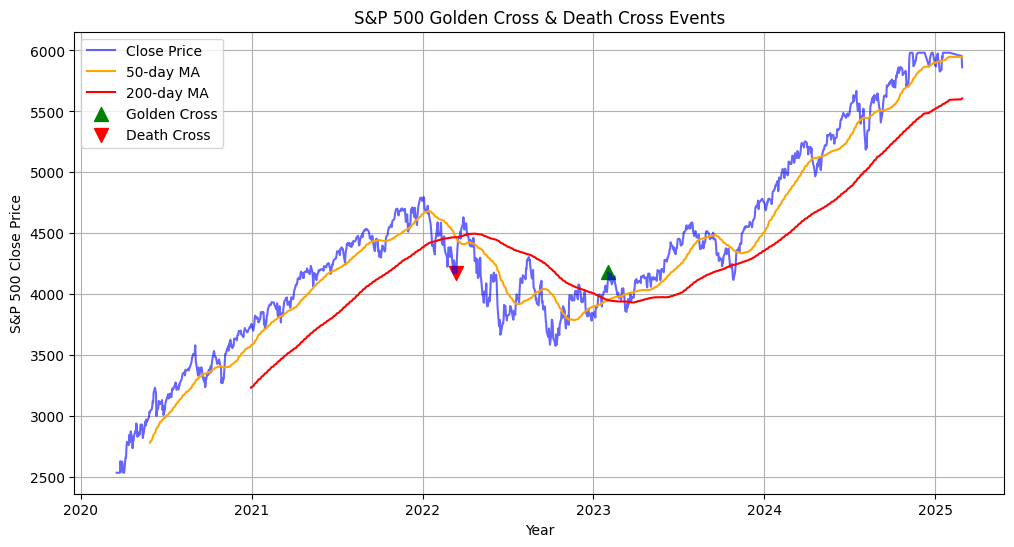

Golden Crosses Detected on:
          Date        Close
725 2023-02-02  4179.759766

Death Crosses Detected on:
          Date        Close
501 2022-03-14  4173.109863


In [25]:
# Identify Golden Cross & Death Cross
df['Signal'] = 0  # Default: No signal
df.loc[df['MA_50'] > df['MA_200'], 'Signal'] = 1  # Golden Cross (Bullish)
df.loc[df['MA_50'] < df['MA_200'], 'Signal'] = -1 # Death Cross (Bearish)

# Find specific crossover points
golden_crosses = df[(df['Signal'] == 1) & (df['Signal'].shift(1) == -1)]
death_crosses = df[(df['Signal'] == -1) & (df['Signal'].shift(1) == 1)]

# 📊 Plot Closing Price with Moving Averages and Crosses
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], label="Close Price", color='blue', alpha=0.6)
plt.plot(df['Date'], df['MA_50'], label="50-day MA", color='orange')
plt.plot(df['Date'], df['MA_200'], label="200-day MA", color='red')

# Mark Golden Cross Events
plt.scatter(golden_crosses['Date'], golden_crosses['Close'], marker='^', color='green', label="Golden Cross", s=100)

# Mark Death Cross Events
plt.scatter(death_crosses['Date'], death_crosses['Close'], marker='v', color='red', label="Death Cross", s=100)

# Labels & Legend
plt.xlabel("Year")
plt.ylabel("S&P 500 Close Price")
plt.title("S&P 500 Golden Cross & Death Cross Events")
plt.legend()
plt.grid(True)
plt.show()

# Print Key Events
print("Golden Crosses Detected on:")
print(golden_crosses[['Date', 'Close']])

print("\nDeath Crosses Detected on:")
print(death_crosses[['Date', 'Close']])

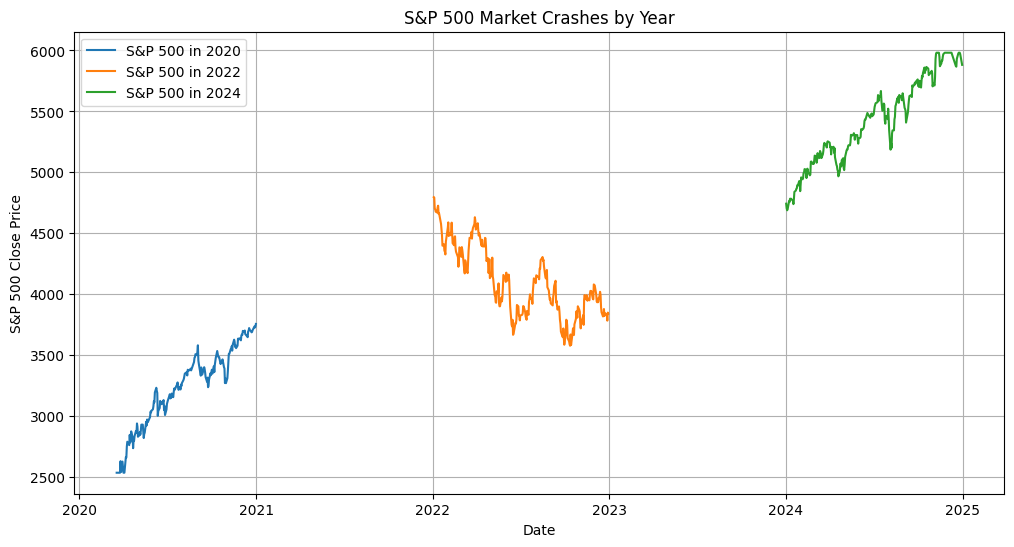

In [26]:
# Define crash years to analyze
crash_years = [2020, 2022, 2024]  # Add more years if needed

# Filter dataset for crash years
df_crash = df[df['Date'].dt.year.isin(crash_years)]

# 📊 Plot Closing Price for Crash Years
plt.figure(figsize=(12, 6))
for year in crash_years:
    yearly_data = df[df['Date'].dt.year == year]
    plt.plot(yearly_data['Date'], yearly_data['Close'], label=f"S&P 500 in {year}")

# Labels & Legend
plt.xlabel("Date")
plt.ylabel("S&P 500 Close Price")
plt.title("S&P 500 Market Crashes by Year")
plt.legend()
plt.grid(True)
plt.show()

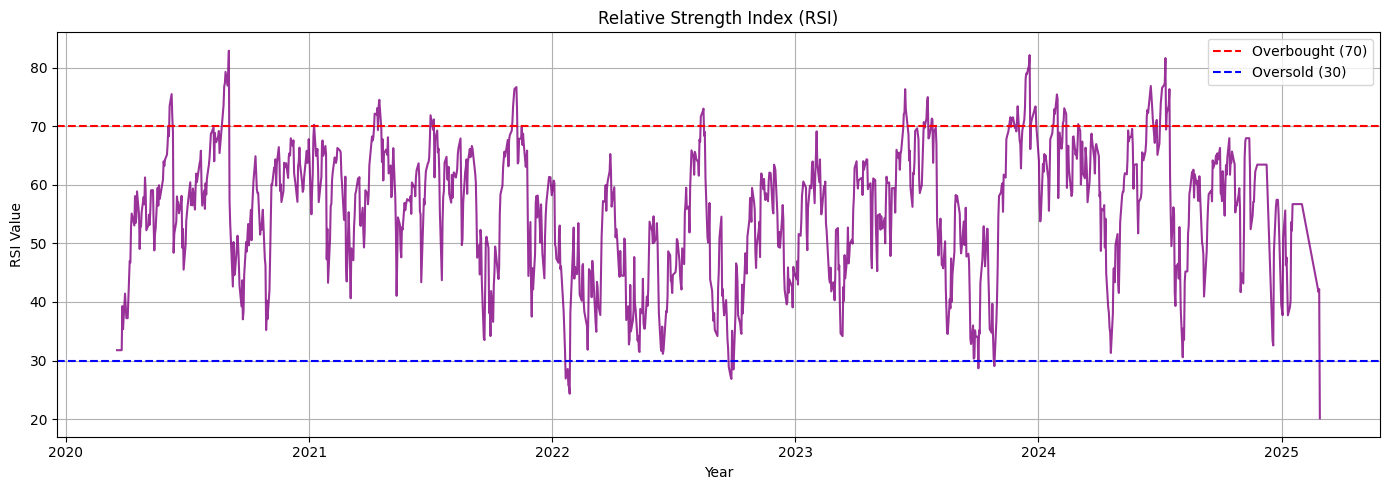

In [27]:
# Set date as index
df.set_index('Date', inplace=True)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.figure(figsize=(14,5))
plt.plot(df['RSI'], color='purple', alpha=0.8)

# Add RSI levels
plt.axhline(70, linestyle='--', color='red', label='Overbought (70)')
plt.axhline(30, linestyle='--', color='blue', label='Oversold (30)')

# Format x-axis to show years from your data (2020–2025)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.title('Relative Strength Index (RSI)')
plt.xlabel('Year')
plt.ylabel('RSI Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


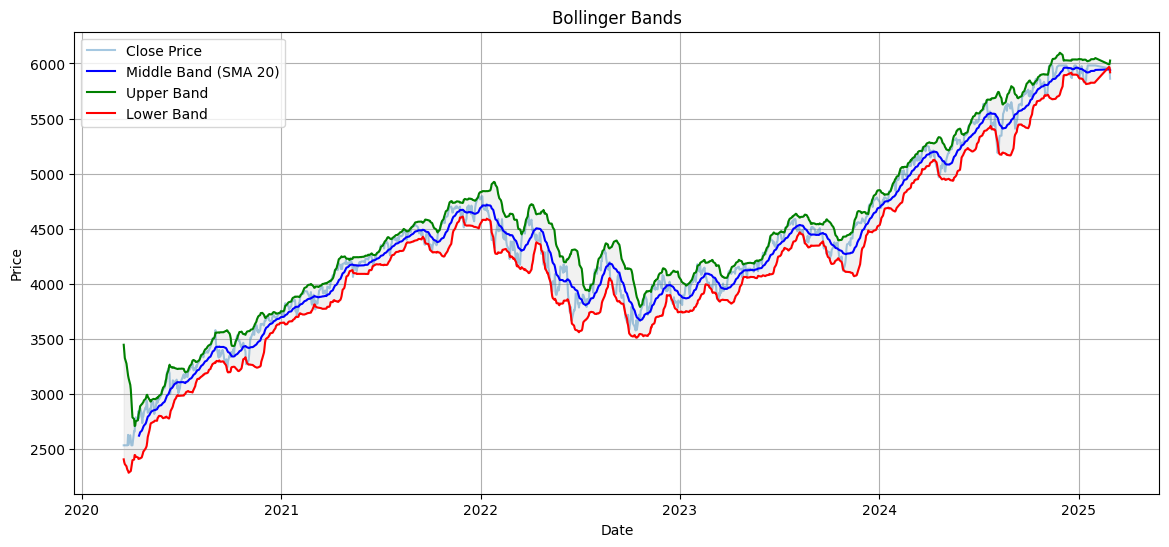

In [28]:
#Visualizing Bollinger brands
plt.figure(figsize=(14,6))
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
plt.plot(df['Close'], label='Close Price', alpha=0.4)
plt.plot(df['BB_Middle'], label='Middle Band (SMA 20)', color='blue')
plt.plot(df['BB_Upper'], label='Upper Band', color='green')
plt.plot(df['BB_Lower'], label='Lower Band', color='red')
plt.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], color='lightgrey', alpha=0.3)
# Format x-axis to show years from your data (2020–2025)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [37]:
#Train XGBoost regressor 
X = df[features]
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
model = XGBRegressor(learning_rate=0.05,n_estimators=300)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.6f}")
print(f"R² Score: {r2:.4f}")


Mean Squared Error: 0.000001
R² Score: 0.9862


In [38]:
# Get the last known price from training set
last_price = df['Close'].iloc[len(X_train)]  # or df.iloc[X_train.index[-1]]['Close']

# Reconstruct predicted prices from predicted log returns
predicted_prices = [last_price]
for r in y_pred:
    next_price = predicted_prices[-1] * np.exp(r)
    predicted_prices.append(next_price)

# Remove the initial seed (we only care about predictions)
predicted_prices = predicted_prices[1:]

# Reconstruct actual prices from true log returns (for comparison)
actual_prices = [last_price]
for r in y_test.values:
    next_price = actual_prices[-1] * np.exp(r)
    actual_prices.append(next_price)
actual_prices = actual_prices[1:]
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

mae = mean_absolute_error(actual_prices, predicted_prices)
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape = mean_absolute_percentage_error(actual_prices, predicted_prices)

print(f"Evaluation in Price Space")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape * 100:.2f}%")


Evaluation in Price Space
MAE:  53.14
RMSE: 63.80
MAPE: 0.93%


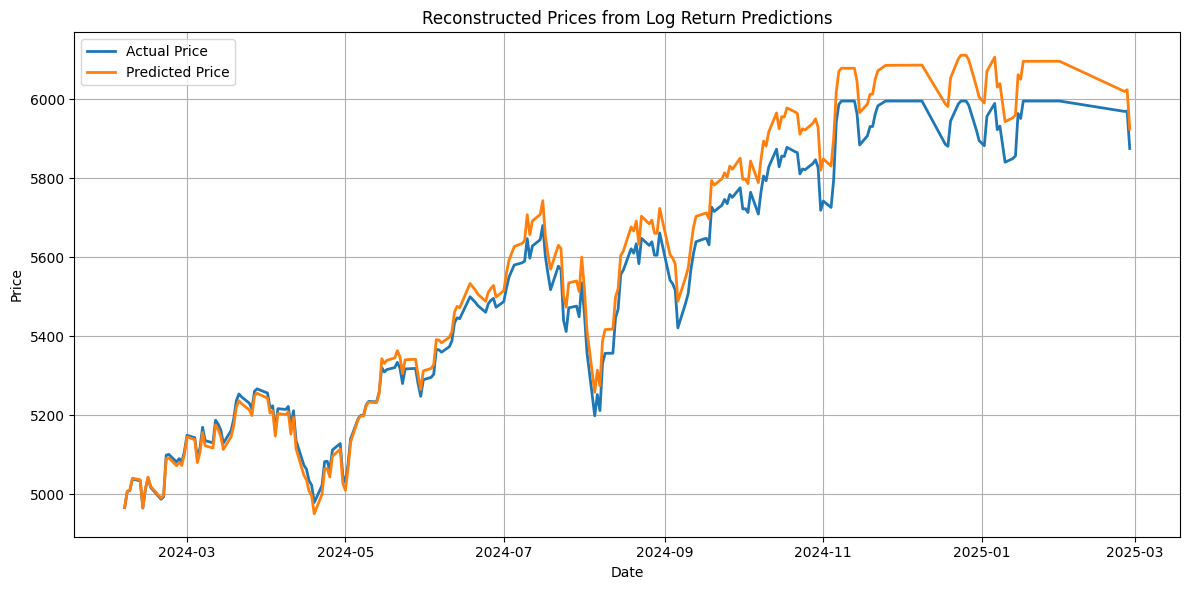

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, actual_prices, label='Actual Price', linewidth=2)
plt.plot(y_test.index, predicted_prices, label='Predicted Price', linewidth=2)
plt.title('Reconstructed Prices from Log Return Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [40]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

param_dist_light = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.03, 0.05],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 1.0],
    'gamma': [0, 1],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}

random_search_light = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_light,
    n_iter=20,     # small number of combinations
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring='neg_mean_squared_error'
)

random_search_light.fit(X_train, y_train)

# Best model and metrics
best_model_light = random_search_light.best_estimator_
print("Best Params (Light Grid):", random_search_light.best_params_)

y_pred_light = best_model_light.predict(X_test)

mse_light = mean_squared_error(y_test, y_pred_light)
r2_light = r2_score(y_test, y_pred_light)

print(f"Tuned Light MSE: {mse_light:.6f}, R²: {r2_light:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Params (Light Grid): {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 500, 'max_depth': 3, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 1.0}
Tuned Light MSE: 0.000001, R²: 0.9801


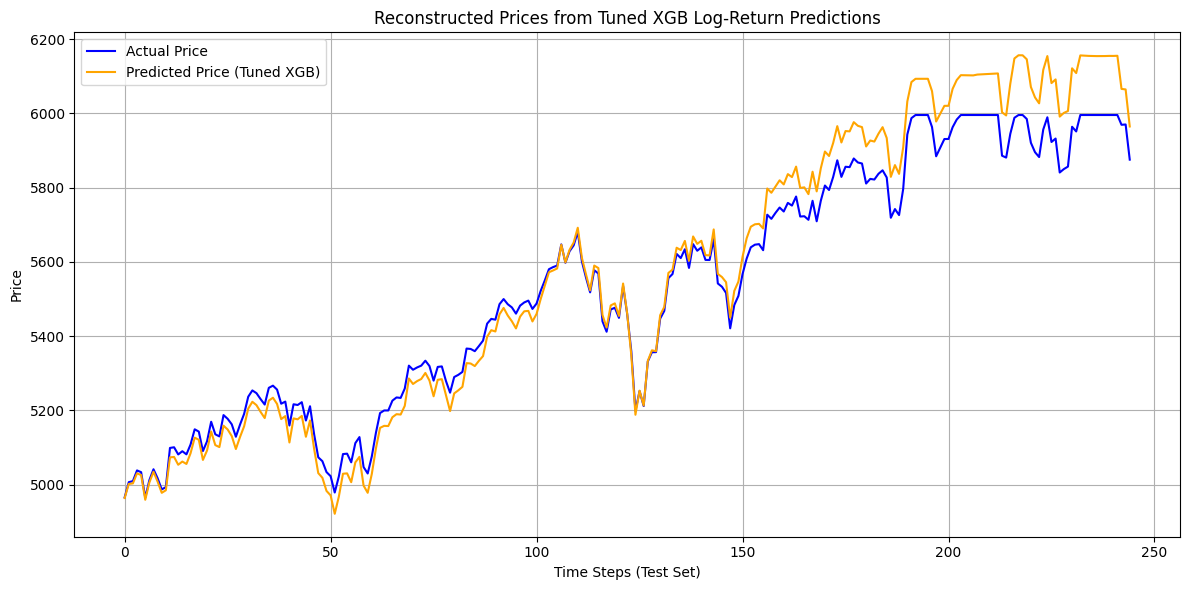

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Convert log return predictions to price series
def reconstruct_prices_from_log_returns(initial_price, log_returns):
    prices = [initial_price]
    for r in log_returns:
        prices.append(prices[-1] * np.exp(r))
    return prices[1:]

# Initial price is last price from training set
initial_price = df.iloc[X_train.shape[0]]['Close']

# Reconstruct price series
actual_prices = reconstruct_prices_from_log_returns(initial_price, y_test)
predicted_prices = reconstruct_prices_from_log_returns(initial_price, y_pred_light)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price (Tuned XGB)', color='orange')
plt.title('Reconstructed Prices from Tuned XGB Log-Return Predictions')
plt.xlabel('Time Steps (Test Set)')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


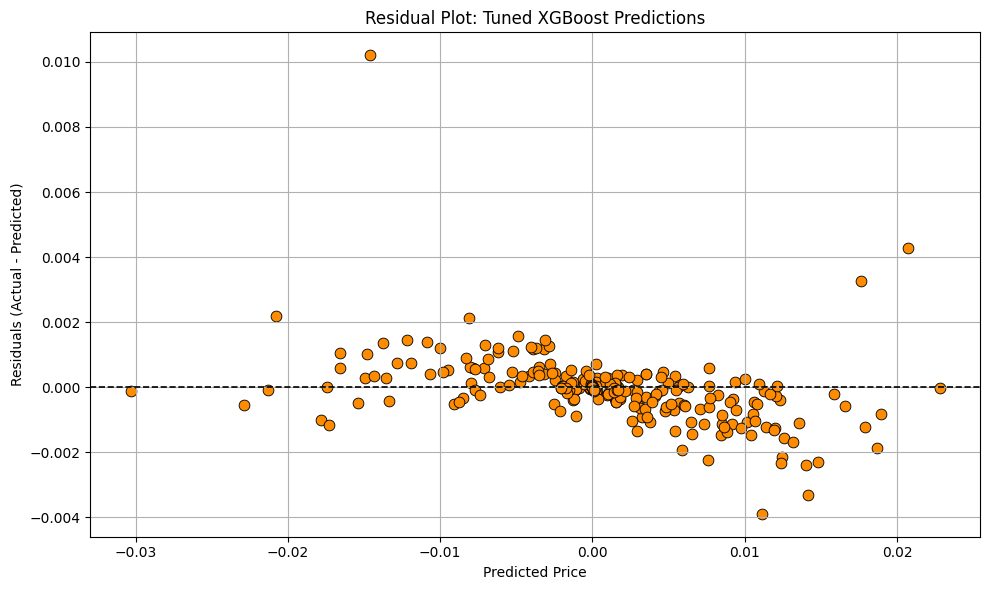

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Residuals
residuals = y_test - y_pred_light

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_light, y=residuals, color='darkorange', edgecolor='black', s=60)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: Tuned XGBoost Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [43]:
mae_price = mean_absolute_error(actual_prices, predicted_prices)
rmse_price = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
mape_price = np.mean(np.abs((np.array(actual_prices) - np.array(predicted_prices)) / np.array(actual_prices))) * 100

print("Evaluation in Price Space (Tuned):")
print(f"MAE:  {mae_price:.2f}")
print(f"RMSE: {rmse_price:.2f}")
print(f"MAPE: {mape_price:.2f}%")


Evaluation in Price Space (Tuned):
MAE:  59.49
RMSE: 75.73
MAPE: 1.04%


In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define features and target
X = df[features]
y = df['LogReturn']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Scale for models that require it
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [45]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)

knn_mse = mean_squared_error(y_test, knn_preds)
knn_r2 = r2_score(y_test, knn_preds)

print(f"KNN Regressor MSE: {knn_mse:.6f}")
print(f"KNN Regressor R²: {knn_r2:.4f}")


KNN Regressor MSE: 0.000010
KNN Regressor R²: 0.8404


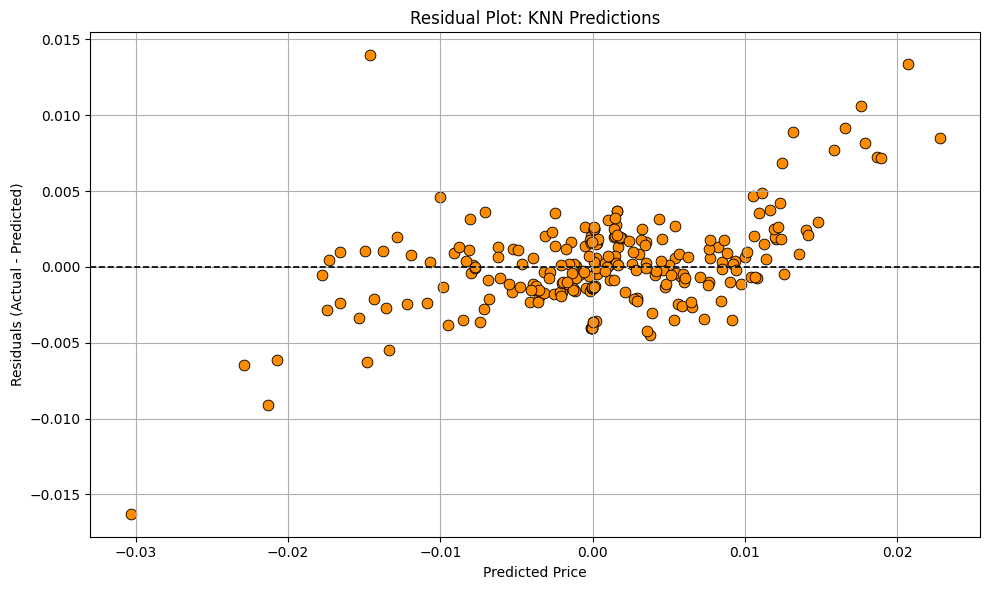

In [46]:
# Residual plot
residuals = y_test - knn_preds

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_light, y=residuals, color='darkorange', edgecolor='black', s=60)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: KNN Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [47]:
from sklearn.svm import SVR

svr = SVR(C=1.0, epsilon=0.001, kernel='rbf')
svr.fit(X_train_scaled, y_train)
svr_preds = svr.predict(X_test_scaled)

svr_mse = mean_squared_error(y_test, svr_preds)
svr_r2 = r2_score(y_test, svr_preds)

print(f"SVR MSE: {svr_mse:.6f}")
print(f"SVR R²: {svr_r2:.4f}")


SVR MSE: 0.000021
SVR R²: 0.6612


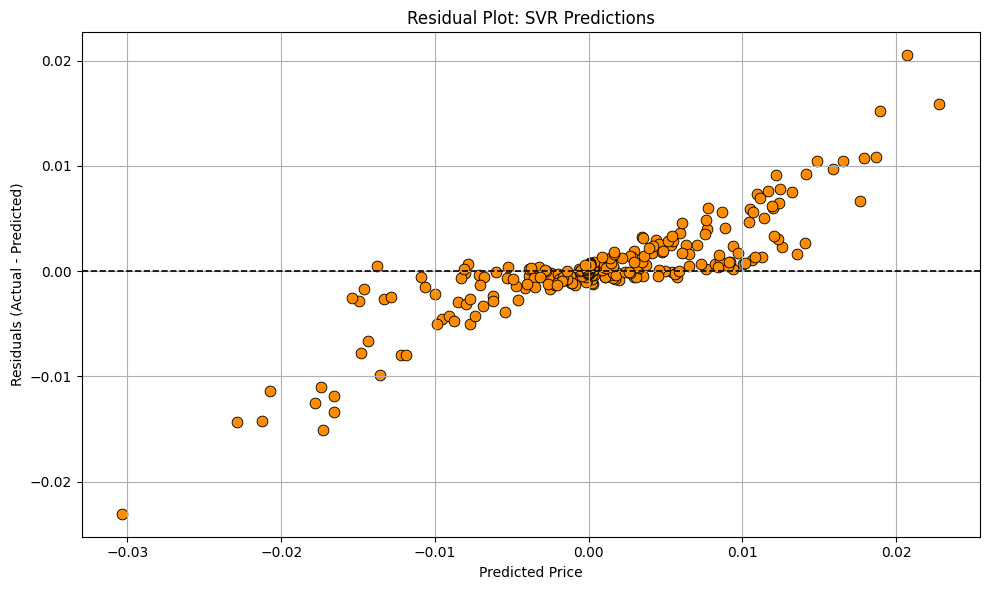

In [48]:
# Residual plot
residuals = y_test - svr_preds

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_light, y=residuals, color='darkorange', edgecolor='black', s=60)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: SVR Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
from lightgbm import LGBMRegressor

lgbm = LGBMRegressor(n_estimators=300, learning_rate=0.05, random_state=42)
lgbm.fit(X_train, y_train)
lgbm_preds = lgbm.predict(X_test)

lgbm_mse = mean_squared_error(y_test, lgbm_preds)
lgbm_r2 = r2_score(y_test, lgbm_preds)

print(f"LGBM Regressor MSE: {lgbm_mse:.6f}")
print(f"LGBM Regressor R²: {lgbm_r2:.4f}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000511 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5355
[LightGBM] [Info] Number of data points in the train set: 978, number of used features: 21
[LightGBM] [Info] Start training from score 0.000683
LGBM Regressor MSE: 0.000001
LGBM Regressor R²: 0.9843


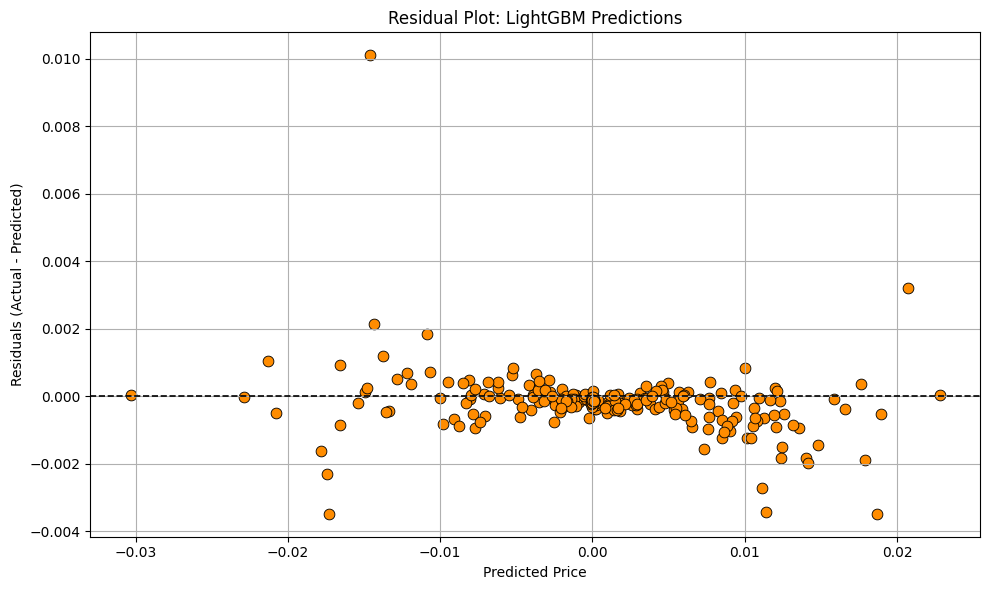

In [43]:
# Residual plot
residuals = y_test - lgbm_preds

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_light, y=residuals, color='darkorange', edgecolor='black', s=60)
plt.axhline(0, color='black', linestyle='--', linewidth=1.2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot: LightGBM Predictions')
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
# Create a DataFrame to compare predictions
results_df = pd.DataFrame(index=y_test.index)
results_df['Actual_LogReturn'] = y_test
results_df['XGBoost'] = y_pred  # From your XGBoost model
results_df['KNN'] = knn_preds
results_df['SVR'] = svr_preds
results_df['LGBM'] = lgbm_preds

# Convert log returns to cumulative price (for better visual interpretation)
initial_price = df['Close'].iloc[X_train.shape[0]]  # starting test price
cumulative_df = np.exp(results_df.cumsum()) * initial_price


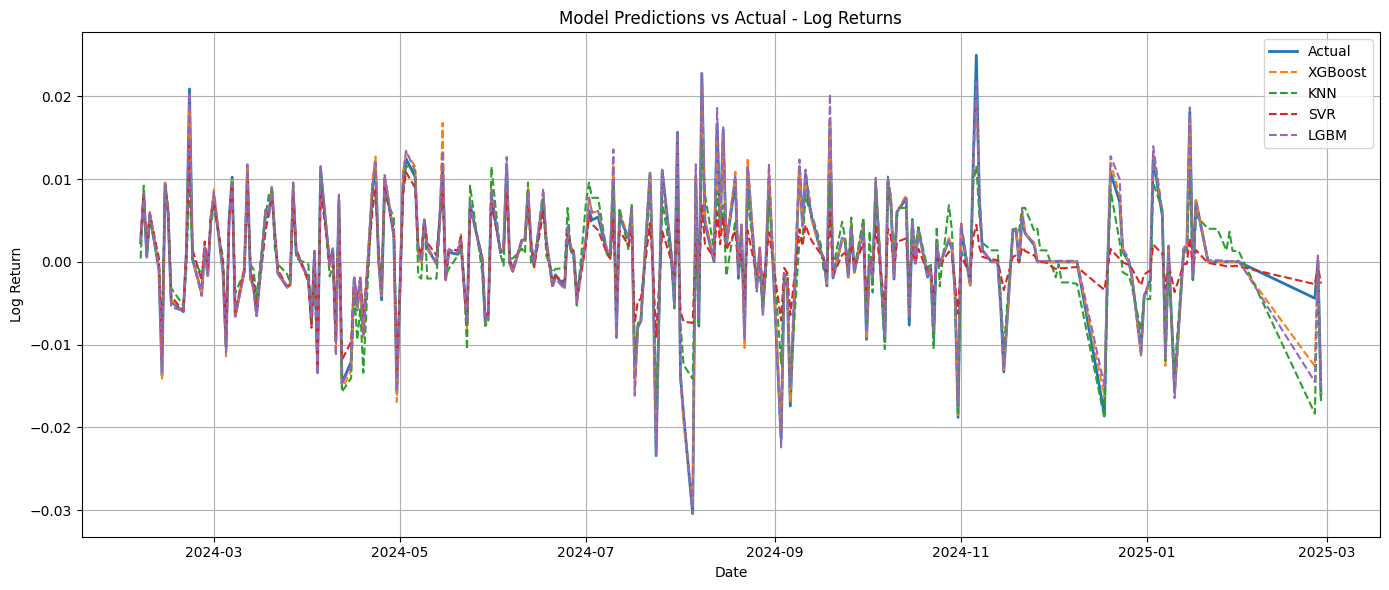

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(results_df['Actual_LogReturn'], label='Actual', linewidth=2)
plt.plot(results_df['XGBoost'], label='XGBoost', linestyle='--')
plt.plot(results_df['KNN'], label='KNN', linestyle='--')
plt.plot(results_df['SVR'], label='SVR', linestyle='--')
plt.plot(results_df['LGBM'], label='LGBM', linestyle='--')
plt.title("Model Predictions vs Actual - Log Returns")
plt.xlabel("Date")
plt.ylabel("Log Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


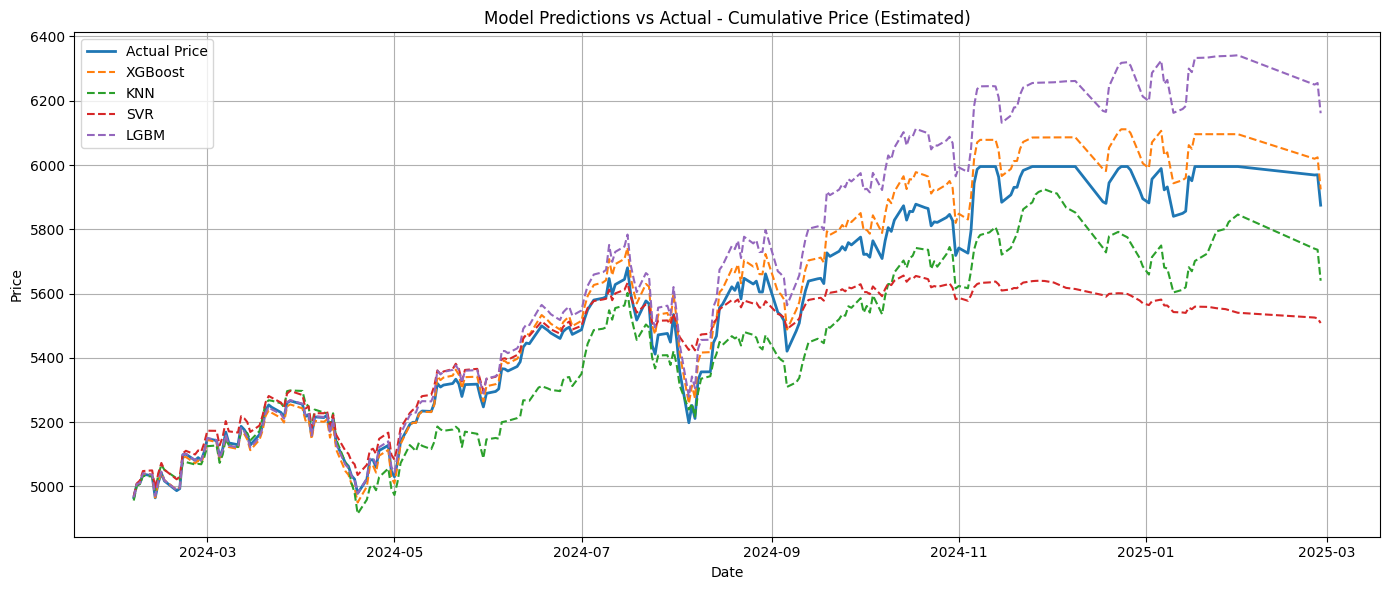

In [46]:
plt.figure(figsize=(14, 6))
plt.plot(cumulative_df['Actual_LogReturn'], label='Actual Price', linewidth=2)
plt.plot(cumulative_df['XGBoost'], label='XGBoost', linestyle='--')
plt.plot(cumulative_df['KNN'], label='KNN', linestyle='--')
plt.plot(cumulative_df['SVR'], label='SVR', linestyle='--')
plt.plot(cumulative_df['LGBM'], label='LGBM', linestyle='--')
plt.title("Model Predictions vs Actual - Cumulative Price (Estimated)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


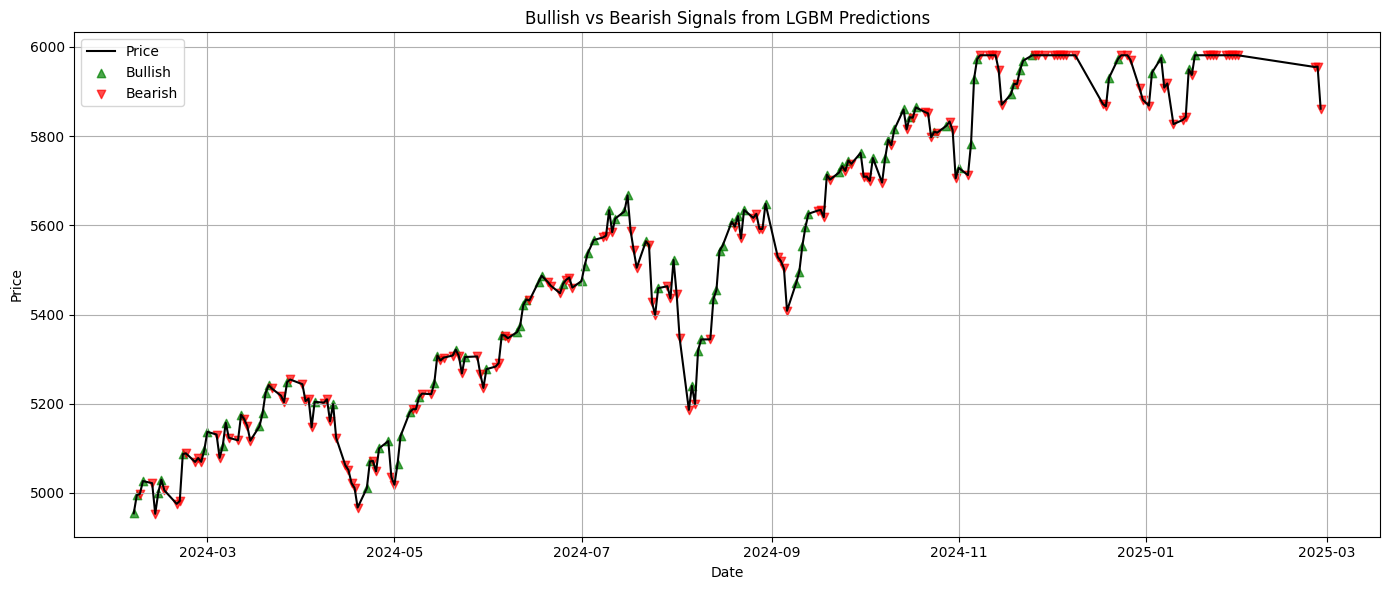

In [47]:
# Define a threshold for "meaningful" predictions
threshold = 0.002  # try 0.001 to 0.005 and test sensitivity

# Initialize signal column to 0 (bearish)
results_df['Signal'] = 0

# Bullish signal: only if prediction is confidently positive
results_df.loc[results_df['LGBM'] > threshold, 'Signal'] = 1


# Optional: add actual price for visualization
results_df['Price'] = df['Close'].loc[y_test.index]
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(results_df['Price'], label='Price', color='black')

# Bullish points
bullish = results_df[results_df['Signal'] == 1]
plt.scatter(bullish.index, bullish['Price'], marker='^', color='green', label='Bullish', alpha=0.7)

# Bearish points
bearish = results_df[results_df['Signal'] == 0]
plt.scatter(bearish.index, bearish['Price'], marker='v', color='red', label='Bearish', alpha=0.7)

plt.title("Bullish vs Bearish Signals from LGBM Predictions")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
